In [1]:
import numpy as np
import torch
from DynGenModels.configs.lhco_configs import LHCOlympics_MLP_CondFlowMatch as Configs

configs = Configs(# data:
                  DATA = 'LHCOlympics',
                  dataset = '../../data/LHCOlympics2020/events_anomalydetection_dijets.h5',
                  cuts_sideband_low = {'mjj': [2700, 3100]},  
                  cuts_sideband_high = {'mjj': [3900, 13000]}, 
                  dim_input = 8,
                  preprocess = None,                            
                  num_dijets = 60000,  
                  # training params:   
                  DEVICE = 'cpu',
                  EPOCHS = 10000,
                  batch_size = 256,
                  print_epochs = 20,
                  early_stopping = 200,
                  data_split_fracs = [0.8, 0.2, 0.0],
                  lr = 1e-4,
                  optimizer = 'Adam',
                  fix_seed = 12345,
                  # model params:
                  MODEL = 'MLP',
                  dim_hidden = 64,
                  num_layers = 3,
                  sigma = 0.0,
                  t0 = 0.0,
                  t1 = 1.0,
                  # sampling params:
                  solver = 'midpoint',
                  num_sampling_steps = 1000,
                )

configs.set_workdir(path='../../results', save_config=True)

#=====================================================================================
INFO: created directory: ../../results/LHCOlympics.CondFlowMatch.MLP.2023.11.01_18h05
#=====================================================================================
+---------------------+--------------------------------------------------------------------+
| Parameters          | Values                                                             |
+---------------------+--------------------------------------------------------------------+
| DATA                | LHCOlympics                                                        |
| dataset             | ../../data/LHCOlympics2020/events_anomalydetection_dijets.h5       |
| features            | ['pt_1', 'eta_1', 'phi_1', 'm_1', 'pt_2', 'eta_2', 'phi_2', 'm_2'] |
| dim_input           | 8                                                                  |
| preprocess          |                                                                  

In [2]:
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsDataset 
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import SimplifiedCondFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

lhco = LHCOlympicsDataset(configs)
cfm = DynGenModelTrainer(dynamics = SimplifiedCondFlowMatching(configs),
                         model = MLP(configs), 
                         dataloader = LHCOlympicsDataLoader (lhco, configs), 
                         configs = configs)

#...train model:

cfm.train()

/Users/dario/Dropbox/PROJECTS/ML/DynGenModels/src/DynGenModels/datamodules/lhco/datasets.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  dijets = torch.Tensor(f['dijet features'])
number of training parameters: 1059848
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 48000, validation size: 12000, testing sizes: 0


epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

	Epoch: 1, train loss: 39936.42785904254, valid loss: 39331.60009765626  (min valid loss: 39331.60009765626)
	Epoch: 21, train loss: 39312.87125997341, valid loss: 39005.1181640625  (min valid loss: 38931.282714843735)
	Epoch: 41, train loss: 38158.897855718074, valid loss: 38325.49609374999  (min valid loss: 37134.52880859375)
	Epoch: 61, train loss: 36599.72392370347, valid loss: 35273.75260416667  (min valid loss: 35273.75260416667)
	Epoch: 81, train loss: 36808.61307347074, valid loss: 35047.824381510414  (min valid loss: 34800.589518229164)
	Epoch: 101, train loss: 36200.862907247334, valid loss: 35965.90169270833  (min valid loss: 34798.278564453125)
	Epoch: 121, train loss: 35483.230738863036, valid loss: 34563.60579427084  (min valid loss: 34466.866373697914)
	Epoch: 141, train loss: 35808.46966422872, valid loss: 34281.03068033855  (min valid loss: 33895.07470703125)
	Epoch: 161, train loss: 34572.9216256649, valid loss: 34780.418212890625  (min valid loss: 33551.47810872396)


In [ ]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 

pipeline = FlowMatchPipeline(trained_model=cfm, 
                             source_input=lhco.source,
                             configs=configs, 
                             best_epoch_model=True)


# Pretrained CFM

Load a previsoiusly trained model that was stored somewhere in a directory. The directory must contain the follwing files:
- `config.json` file with all the parameters used during the training.
- `best_epoch_model.pth` model file corresponding the trained model that had the lowest validation loss.
- `last_epoch_model.pth` model file corresponding the last epoch trained model.


### 1. Load pre-trained model
 

In [11]:
#...provide the directory of the trained model and load the configuration file in it:

from DynGenModels.configs.lhco_configs import LHCOlympics_MLP_CondFlowMatch as Configs

model_workdir = '../../results/LHCOlympics.CondFlowMatch.MLP.2023.11.01_21h31'
configs = Configs().load(model_workdir + '/config.json')
configs.DEVICE = 'cuda:3'   # select device
configs.workdir = model_workdir

#...be sure to use the same dataset, dataloader and model that was used for training the pre-trained model:

from DynGenModels.datamodules.lhco.datasets import LHCOlympicsDataset 
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import SimplifiedCondFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

lhco = LHCOlympicsDataset(configs)
pretrained_cfm = DynGenModelTrainer(dynamics = SimplifiedCondFlowMatching(configs),
                                    model = MLP(configs), 
                                    dataloader = LHCOlympicsDataLoader(lhco, configs), 
                                    configs = configs)

#...load the pre-trained model:

pretrained_cfm.load(model='best')

+---------------------+--------------------------------------------------------------------+
| Parameters          | Values                                                             |
+---------------------+--------------------------------------------------------------------+
| DATA                | LHCOlympics                                                        |
| dataset             | ../../data/LHCOlympics2020/events_anomalydetection_dijets.h5       |
| features            | ['pt_1', 'eta_1', 'phi_1', 'm_1', 'pt_2', 'eta_2', 'phi_2', 'm_2'] |
| dim_input           | 8                                                                  |
| preprocess          |                                                                    |
| cuts_sideband_low   | mjj: [2700, 3100]                                                  |
| cuts_sideband_high  | mjj: [3900, 13000]                                                 |
| num_dijets          | 60000                                         

### 2. sample from loaded models

In [12]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 

pipeline = FlowMatchPipeline(trained_model=pretrained_cfm, 
                             source_input=lhco.source,
                             configs=configs, 
                             best_epoch_model=True)

INFO: neural ODE solver with midpoint method and steps=1000


### Plot results:

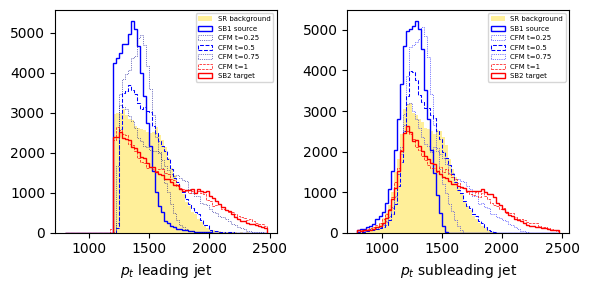

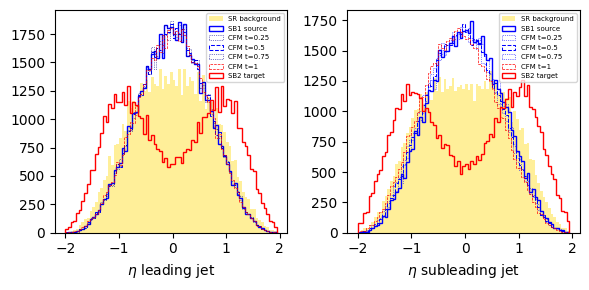

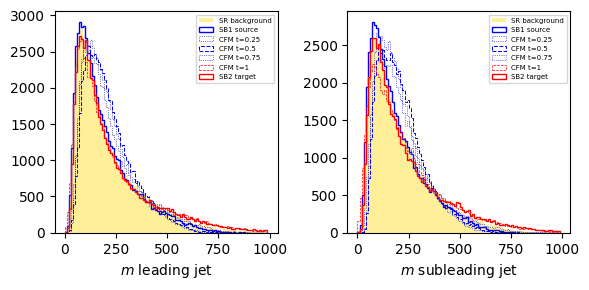

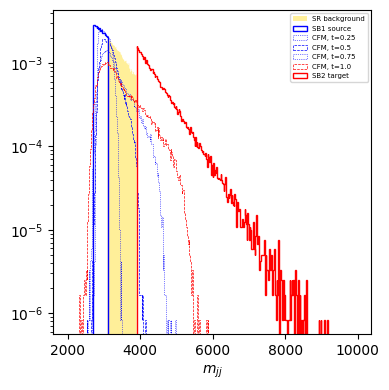

In [13]:
import numpy as np
from utils import plot_jet_features, plot_dijet_mass

STEP = configs.num_sampling_steps/2
D_STEP = configs.num_sampling_steps/4

plot_jet_features(lhco, pipeline.trajectories, 'p_t', time_step=STEP, d_step=D_STEP, xlim=(800, 2500, 25))
plot_jet_features(lhco, pipeline.trajectories, '\eta', time_step=STEP, d_step=D_STEP, xlim=(-2, 2, 0.05))
plot_jet_features(lhco, pipeline.trajectories, 'm', time_step=STEP, d_step=D_STEP, xlim=(0, 1000, 10))
plot_dijet_mass(lhco, pipeline.trajectories, bins=np.arange(2000, 10000, 20), time_step=STEP, d_step=D_STEP, figsize=(4,4))